In [ ]:
!cd ..;python -m pip install . 

In [1]:
import pystorm as pst
from pystorm.utils import minitorch as mnt
from pystorm.utils.type_safety import ensure_torch, ensure_numpy

In [6]:
def welch_psd_source_space(ker, sensor, fs, window_length=2000, overlap = 0.5, device = "cpu"):
    nTime = sensor.shape[-1]
    Lwin = round(window_length/1000*fs)
    Loverlap = round(Lwin * overlap)
    Lwin = Lwin - Lwin%2
    Nwin = int((nTime - Loverlap)/(Lwin-Loverlap))

    freqs = mnt.rfftfreq(Lwin,1/fs).to(device)
    ker_cuda = ensure_torch(ker).to(device).type(mnt.complex64)
    sensor_cuda = ensure_torch(sensor).to(device)
    hamming_window = (0.54 - 0.46 * mnt.cos(mnt.linspace(0,2*mnt.pi,Lwin))).to(device)

    win_noise_power_gain = (hamming_window**2).sum()
    scaling_term = (2/(win_noise_power_gain*fs)).sqrt()
    time_sequence = mnt.arange(0,Lwin, dtype = int)

    fft_blocks = 0
    for i in range(Nwin):
        iTimes =  time_sequence + (i - 1)*(Lwin-Loverlap)
        block = sensor_cuda[:,iTimes]
        source_ts = (block) * hamming_window
        fft_res = mnt.rfft(source_ts,dim = -1) * scaling_term
        fft_res[:,1:] /= 2**(1/2)
        fft_blocks += (ker_cuda @ fft_res).abs()**2/Nwin
    return ensure_numpy(fft_blocks), ensure_numpy(freqs)

def welch_psd_sensor_space(sensor, fs, window_length=2000, overlap = 0.5, device = "cpu"):
    nTime = sensor.shape[-1]
    Lwin = round(window_length/1000*fs)
    Loverlap = round(Lwin * overlap)
    Lwin = Lwin - Lwin%2
    Nwin = int((nTime - Loverlap)/(Lwin-Loverlap))

    freqs = mnt.rfftfreq(Lwin,1/fs).to(device)
    sensor_cuda = ensure_torch(sensor).to(device)
    hamming_window = (0.54 - 0.46 * mnt.cos(mnt.linspace(0,2*mnt.pi,Lwin))).to(device)

    win_noise_power_gain = (hamming_window**2).sum()
    scaling_term = (2/(win_noise_power_gain*fs)).sqrt()
    time_sequence = mnt.arange(0,Lwin, dtype = int)

    fft_blocks = 0
    for i in range(Nwin):
        iTimes =  time_sequence + (i - 1)*(Lwin-Loverlap)
        block = sensor_cuda[:,iTimes]
        source_ts = (block) * hamming_window
        fft_res = mnt.rfft(source_ts,dim = -1) * scaling_term
        fft_res[:,1:] /= 2**(1/2)
        fft_blocks += (fft_res).abs()**2/Nwin
    return ensure_numpy(fft_blocks), ensure_numpy(freqs)

In [3]:
fs = 400
length = 5
ker = mnt.cat([mnt.eye(3),mnt.eye(3)])
sensor = mnt.ones(3,int(length*fs)) 
sensor[0] *= mnt.cos(mnt.linspace(0,length,length*fs)*5*2*mnt.pi)
sensor[1] *= mnt.cos(mnt.linspace(0,length,length*fs)*10*2*mnt.pi)
sensor[2] *= mnt.cos(mnt.linspace(0,length,length*fs)*15*2*mnt.pi)

In [5]:
# If you don't already have matplotlib installed, uncomment and run the line below
#!python -m pip install matplotlib

import matplotlib.pyplot as plt

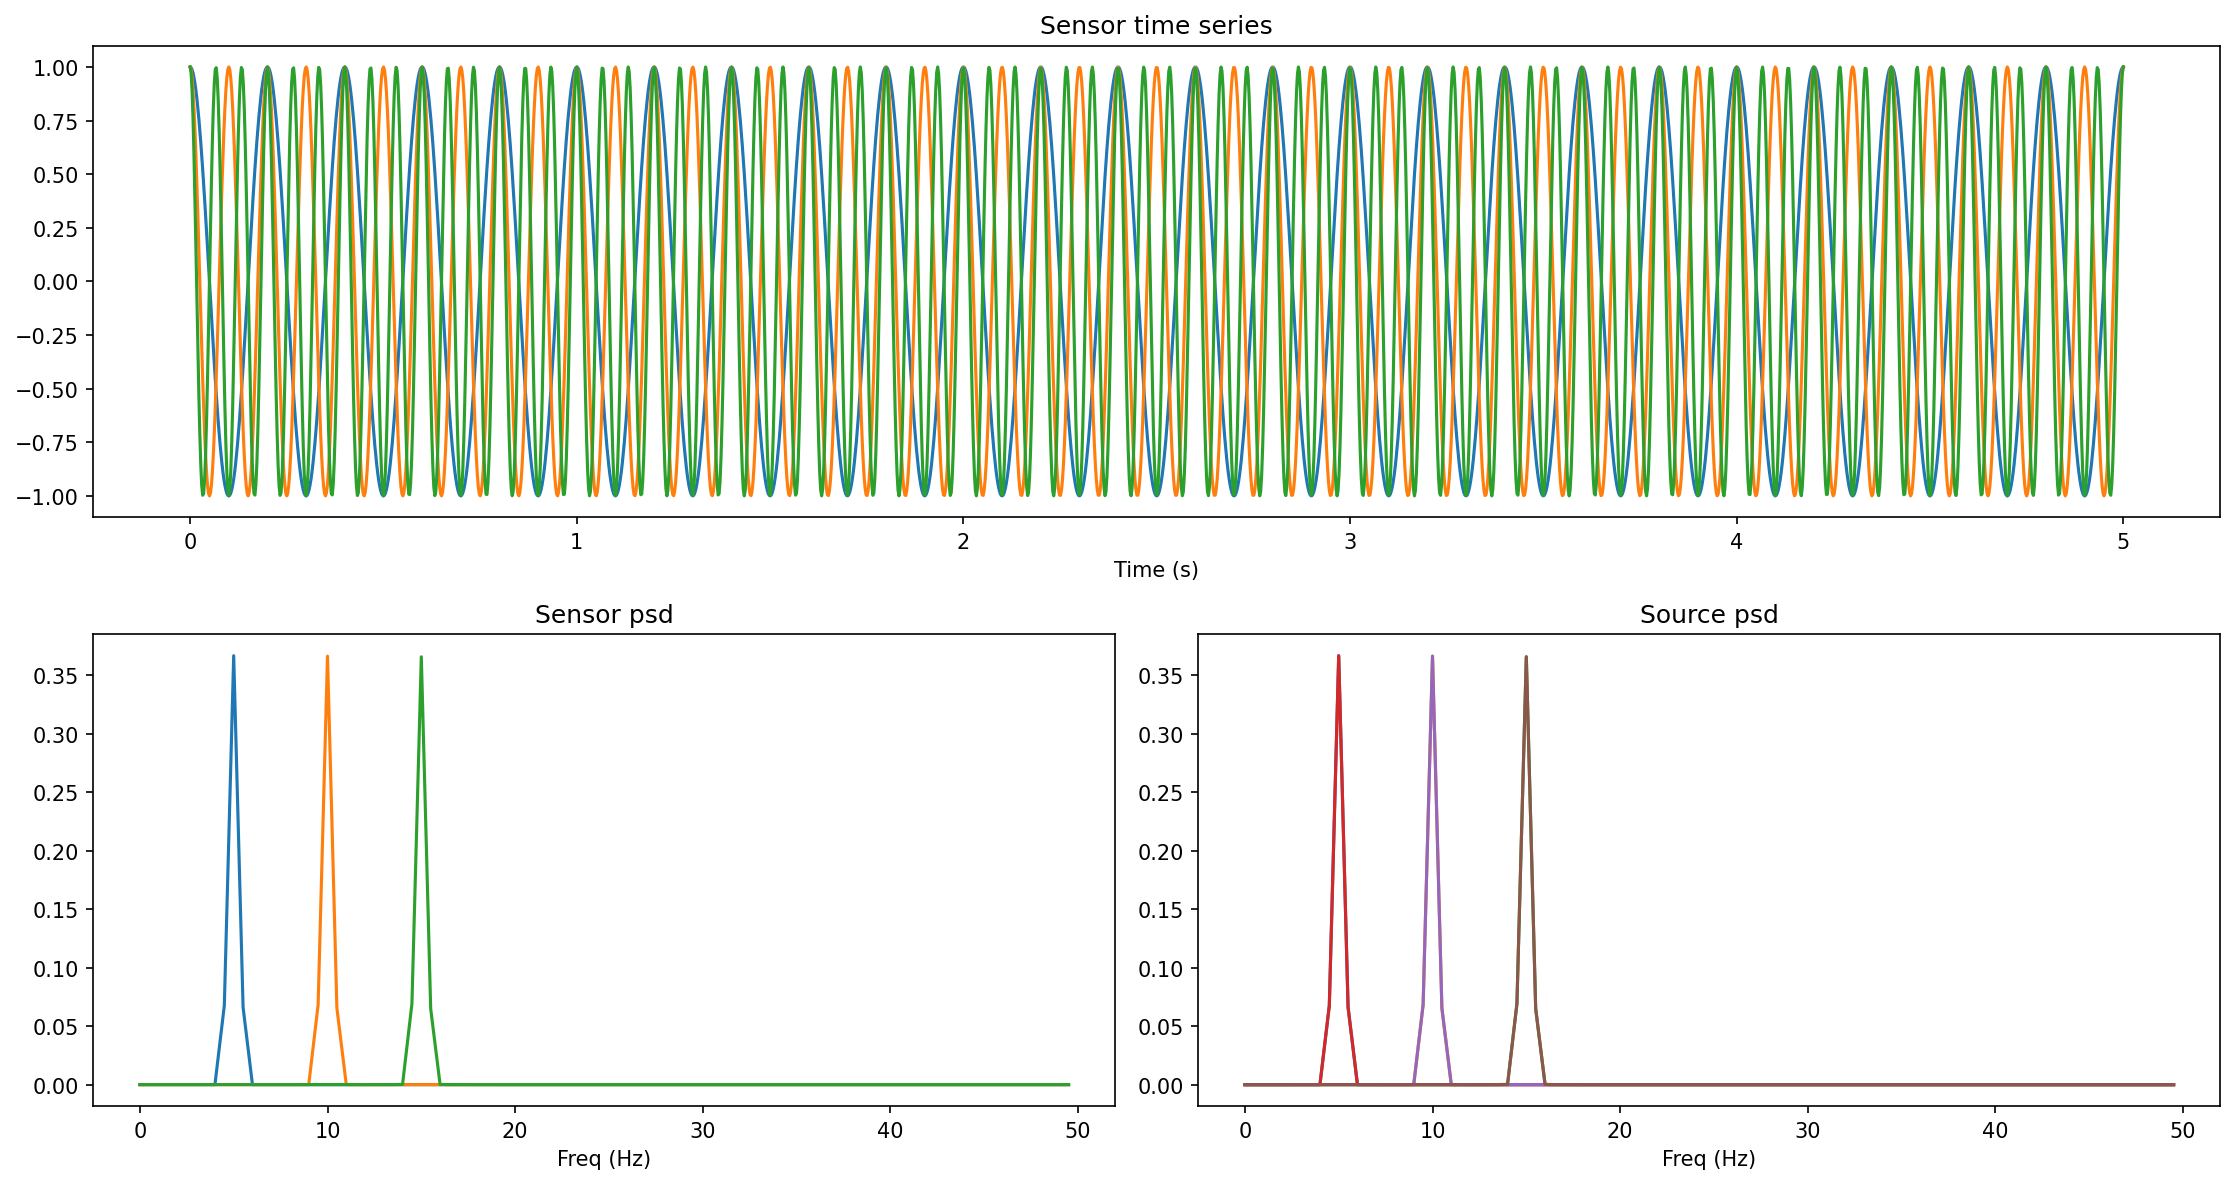

In [6]:
source_psd, freqs = pst.welch_psd_source_space(ker,sensor,fs, device = "cuda")
sensor_psd = pst.welch_psd_sensor_space(sensor,fs, device = "cuda")[0]
freq_mask = freqs<50
fig = plt.figure(figsize = (15,8), dpi = 150)
ax = plt.subplot(2,1,1)
plt.plot(mnt.linspace(0,length,length*fs),sensor.T)
plt.title("Sensor time series")
plt.xlabel("Time (s)")
ax = plt.subplot(2,2,3)
plt.plot(freqs[freq_mask], sensor_psd.T[freq_mask])
plt.xlabel("Freq (Hz)")
plt.title("Sensor psd")
ax = plt.subplot(2,2,4)
plt.plot(freqs[freq_mask],source_psd.T[freq_mask])
plt.xlabel("Freq (Hz)")
plt.title("Source psd")
plt.tight_layout()
plt.show()